# Stack Overflow - Question Modeling for Quality-of-Life
**Author:** Will Dougherty
***

## Overview

With millions of questions and answers, Stack Overflow is a uniquely positioned resource for the coding community. Though often criticized and complained about, it's an invaluable tool to find answers and discussion about very specific coding problems very quickly.

In this project, I used Natural Language Processing (NLP) to predict both quality and the tags for Stack Overflow questions, to provide the foundation for implementing features that could be used in the moment of posting - that is, a user could be alerted if their post is likely to be low-quality, and tags could be suggested based on the text of the question. In both cases, the models do a good job of accomplishing their objectives, and the analysis that led to them informs their best usage and implementation.

### Business Problem

Stack Overflow also occupies a unique position in that it is in the form of a Q&A platform, but is often used as a wiki, or general knowledge base. With aggressive post moderation (i.e. removal of duplicate/already-answered questions) and an upvote system, the focus of the site is on both quality, and ease of search.

#### Stakeholder for project

Thus the two main components of this project are:
- Question quality
- Tagging

Anything that can be done in the moment of posting a question, before it's 'out in the wild', will help take the pressure off of the moderation team and all of the behind-the-scenes tools that are used to help weed out bad posts, and to make sure that proper tags are assigned.

#### I. Quality

This component aims to predict, without an imbalance of false negatives and positives, whether a post is 'high' or 'low' quality - a binary classification. If a user's question is then compared against this model, they can be alerted if it is likely to be low quality, and given a chance to review the post guidelines and re-examine the question before posting it.

#### II. Tagging

This component aims to predict, and then suggest, a field of most-likely tags for a given question. Currently, the user is presented with an empty entry field; although it auto-completes as you type tag names, it isn't based on the text of the just-written question.

Because of the subjective nature of tagging, it would be best to suggest the top 20 or so tags that are most likely to apply to a given question's text. This allows the user to select the ones they feel are most applicable, and even if all of the 'true' tags aren't present, the model is accurate enough that it will likely help the user remember/be reminded of tags that they may not have otherwise thought of.

***
## Question Quality

### Data

There are several datasets of Stack Overflow post data, and for this component I am using two different datasets:

- 60k Stack Overflow Questions with Quality Rating
https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate

This is used to build the model, as it contains ground-truth quality ratings. It is limited to only posts with the 'python' tag.

- Python Questions from Stack Overflow
https://www.kaggle.com/datasets/stackoverflow/pythonquestions

This is much larger, and is used to see how the smaller dataset's model compares against a larger dataset. This is not used to build the model because there is no concrete 'quality' rating, and only things like 'Score' and 'answer_count' are available.

However, as we'll see, the smaller model does seem to have correllation with those aspects of the larger dataset, which suggests further work is warranted.

### Methodology and Goals

In order to predict quality, the text must be cleaned and vectorized, and class imbalance addressed.

For modelling, Logistic Regression is relatively cheap (in system resources and training time) and well-suited to this relatively straightforward modelling problem.

With only the binary classification to deal with, a confusion matrix will be the best way to see the results. A balanced pair of True Positive/False Positive accuracy scores will be used to validate the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import hamming_loss

from time import time

# custom data prep module
import code.data_preparation as data_prep

%matplotlib inline

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [65]:
quality_60k = data_prep.quality_60k_full_clean()

In [66]:
quality_60k.head()

,text,target
0,java repeat task random second familiar repeat...,0
1,java option immut like understand java option ...,1
2,text overlai imag darken opac react nativ atte...,1
3,ternari oper swift picki question simpl answer...,1
4,hide fab scale anim custom floatingactionmenu ...,1


Based on EDA, I was able to find an optimal (or at least high-performing) method of cleaning the text data:

- combine title and body text
- remove HTML tags
- remove code
- remove stopwords
- stemming
- other misc. cleanup (whitespace, etc)

This can be seen in the first few columns above.

***
In order to test the model, I'll split it into train and test portions.

I'll simply select the first 80% and the last 20%, since a real-world application would always be using a model built on past posts that are then tested on future posts.

In [67]:
len_60k = len(quality_60k)
split = int(len_60k/5)

q_train = quality_60k.iloc[:-split]
q_test = quality_60k.iloc[-split:]

X_train = q_train['text']
X_test = q_train['text']

y_train = q_train['target']
y_test = q_train['target']

In order to model this, vectorization of the text is required.

In [68]:
def vectorize_text(train, test):
    vectorizer = TfidfVectorizer()
    train = vectorizer.fit_transform(train)
    test = vectorizer.transform(test)
    
    return train, test

In [69]:
X_train, X_test = vectorize_text(X_train, X_test)

After using a straightforward Tf-Idf vectorizer, we then also have to deal with class imbalance:

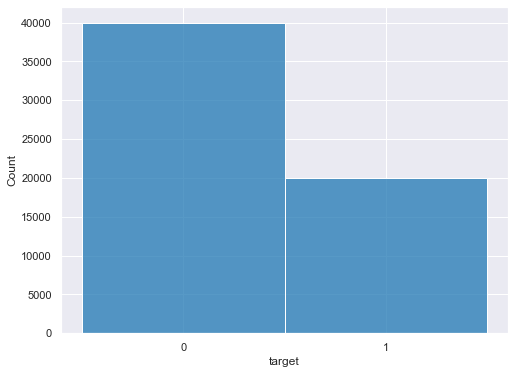

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(quality_60k, x='target', discrete=True)
ax.set_xticks([0,1]);

Using the RandomOverSampler, we can generate more of the '1' (high-quality) samples, so as to help the model train properly.

In [71]:
ROS = RandomOverSampler()

X_train, y_train = ROS.fit_resample(X_train, y_train)

Finally, fitting the LogisticRegression model with tuned hyperparameters allows us to see plot how well it does at predicting the two classes.

In [72]:
lr = LogisticRegression(penalty='l2', solver='lbfgs', C=1, max_iter=1000)

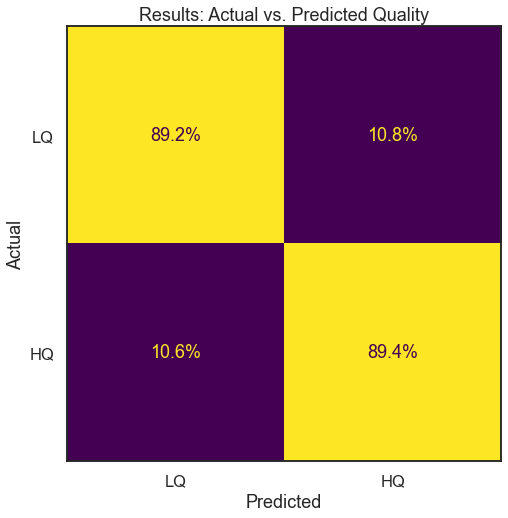

In [209]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
sns.set_style('white')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true',
                                        values_format='.1%',
                                        ax=ax, colorbar=False)
ax.set_xticklabels(['LQ', 'HQ'])
ax.set_yticklabels(['LQ', 'HQ'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.title('Results: Actual vs. Predicted Quality')
plt.savefig('./images/conf_matrix.png');

#### Evaluation

So we see a strong result here. With 89% of the 'low quality' label, and 89% of the 'high quality' label correctly predicted, we don't have a skew either way that would disproportionately affect either target class. False positives would allow low-quality posts to slip through, and false negatives would annoy users who are writing a high-quality question.

##### Vs. Baseline model

A baseline model would simply predict '0' for every class, and thus achieve an accuracy of 67% since 2/3 of the samples are in the '0' class. Thus, the model does a good job of not only improving on accuracy, but actually distinguishing the two classes, and balancing it almost perfectly.

***

To add on to this, because of the lackluster results of directly modelling the larger Python Q&A dataset, I'll take a look at how well this smaller model can do in labelling the larger dataset's samples, and how that lines up with the 'Score' and 'answer_count' features, since those are the closest proxy for 'quality' in that dataset.

I will use the entire 60k dataset as the training data, and test it on 100,000 samples of the larger Python dataset.

In [12]:
python_qa = data_prep.quality_python_full_clean()

X_train, X_test = vectorize_text(quality_60k['text'], python_qa['text'])

y_train = quality_60k['target']

X_train, y_train = ROS.fit_resample(X_train, y_train)

lr = LogisticRegression(penalty='l2', solver='lbfgs', C=1, max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

python_qa['target'] = y_pred

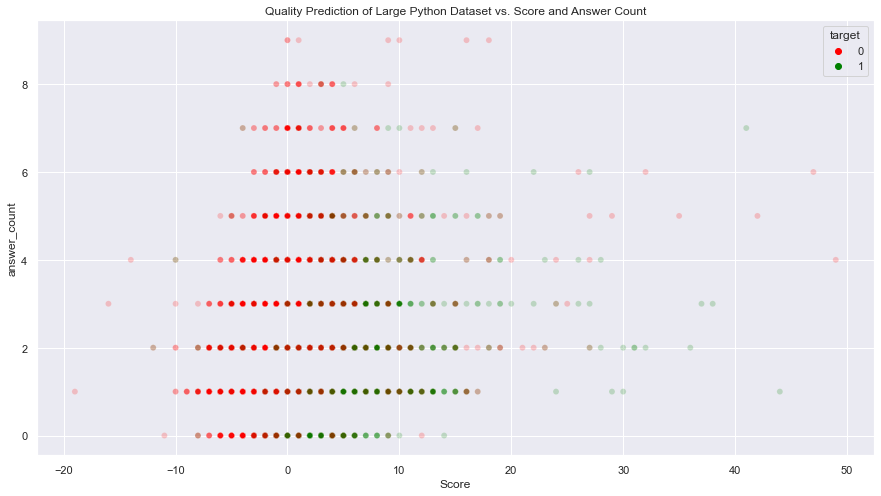

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=python_qa[(python_qa['answer_count']<10) & (python_qa['Score']<50)],\
                y='answer_count', x='Score', hue='target', alpha=.2, palette=['r','g'])
ax.set_title('Quality Prediction of Large Python Dataset vs. Score and Answer Count');

There is a clear correlation between Score and the predicted quality target.

The nature of the datasets is likely somewhat different, since the 60k dataset probably has posts that were removed because of low quality, and the Python Q&A dataset likely only has posts that are still up.

However, this is encouraging to see such a clear gradient from left to right, which suggests that with more data on post quality from Stack Overflow, a very high-performing model could be built to predict quality and alert users.

***
***
## Tag Prediction and Suggestion

### Data

For this component, I will use this large dataset:

- StackSample: 10% of Stack Overflow Q&A
https://www.kaggle.com/datasets/stackoverflow/stacksample?datasetId=265&sortBy=commentCount&select=Questions.csv

It is structured identically to the Python Q&A dataset, but includes posts with all tags. Limiting it to the 'Python' tagged posts creates issues with how it's modelled and validated.

### Methodology and Goals

The goal is a model that can provide suggested tags to a user, before they post their question. Users are given an entry field to enter tags, but it only auto-completes when you start typing. This can enable better and faster tagging for users, and facilitate better searching and generation of 'related post'-type features on the site.

The model itself is predicting tags for each post, but to generate a top-20 list of suggested tags, the model needs to provide probabilities the for all tags for that post.

So ultimately, to achieve this, a Multi-Label Classification model is needed. This is in fact a collection of models, one for each label class (tag), that generates probabilites for each tag for each post. It becomes easy to imagine that this can quickly get out of hand, both in memory usage and training time.

***

To that end, a balance has to be struck regarding number of samples and number of tags to include in the model; below, we'll see the quarterly post counts to give a sense for how many posts are created over time.

In [3]:
def plot_quarterly_posts():
    df = pd.read_csv('./data/QA_all/Questions.csv', encoding='latin1')
    df['time'] = pd.to_datetime(df['CreationDate'], infer_datetime_format=True)
    df['quarter'] = [x.quarter for x in df['time']]
    df['year'] = [x.year for x in df['time']]
    df['quarter'] = df['year'].apply(str).apply(lambda x: x[-2:]) + '-' + df['quarter'].apply(str)
    
    fig, ax = plt.subplots(figsize=(16,8))
    sns.histplot(df['quarter'], discrete=True)
    plt.show()
    del df

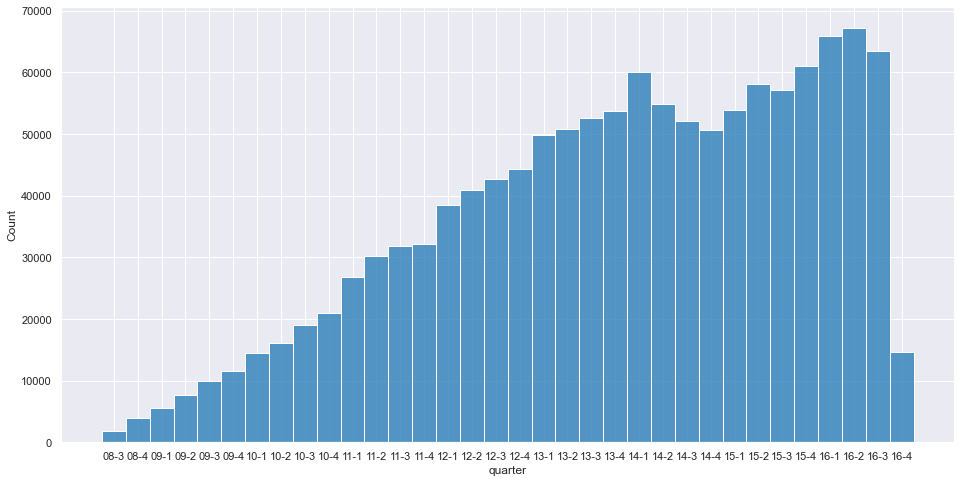

In [4]:
plot_quarterly_posts()

## Data Preparation

Because of its similarity to the Python dataset, the same preparation steps will be undertaken for this dataset.

The only difference is in including the tags, which are simply joined into a list for each post.

In [3]:
# This may take a few minutes!

qa_all = data_prep.tags_full_clean()

In [4]:
qa_all.head()

,Id,text,tags
1064216,34855670,displai null valu cgridview null valu foreignk...,"[php, yii]"
1064217,34855700,input type text icon miss html input box input...,"[html, twitter-bootstrap, icons]"
1064218,34855780,send post request dataoutputstream work read j...,"[java, post, https]"
1064219,34855790,variabl javascript function run javascript val...,[javascript]
1064220,34855800,crystal report page setup dot matrix printer r...,[crystal-reports]


## Data Modeling

As said before, a balance has to be found regarding the number of samples to build the model with, and how many tags to use - the latter will determine how many individual classifiers will need to be trained.

***
### Number of Samples

The dataset has 1,264,216 posts, with many more answers, and tags for each post.

Since it would be prohibitive to build a model with every sample unless it was obviously much more accurate, I investigated whether the tag usage changes drastically over time, which would suggest that smaller models built using a subset of the data that is more similar to the data to be predicted would yield better results.

![graph1](./images/usage_1.png)

![graph2](./images/usage_2.png)

Among the top-256 tags, these show that the fastest-growing and -shrinking tags are definitely fluctuating drastically in proportion to the field of tags in the entire dataset.

Let's also look at how much the ranking of top tags changes over time.

RBO (Rank Biased Overlap) is a measure of similarity between two ranked lists, and is appropriate here because of the nature of the top-tags rankings over time. This measure accounts for position as well as whether tags exist in both lists. Below, we'll see the measure of each quarter's RBO when its top rankings are compared with the previous quarter's.

RBO is interpreted as a measure of similarity, with 1.0 being exactly the same, and 0.0 as completely different lists.

RBO resources:

https://github.com/ragrawal/measures/blob/master/measures/rankedlist/RBO.py

https://ragrawal.wordpress.com/2013/01/18/comparing-ranked-list/

http://codalism.com/research/papers/wmz10_tois.pdf

![graph3](./images/RBO.png)

As we can see, the amount of RBO similarity stabilizes around .55 - .65, so there is (colloquially) a quarter-to-quarter churn of about 35-45% in terms of the top-tag rankings.

***

Thus, it would make sense to only use data that is relatively recent to the data that you want to predict tags for.

In the EDA and prep/modeling notebooks, more exhaustive exploration of this is undertaken. Ultimately, a subset of 200,000 samples seems to make the most sense here, as that accounts for roughly the last year or so of data, and is a nice balance between being hyper-focused on a period of time, and building a large, robust model.

***

### Number of Tags

The tags of the dataset are unevenly distributed among the posts. A small number account for the vast majority of used tags, and a very large number of tags are used very rarely, or even just once.

Below is a representation of how many posts have at least one of the top-n tags:

In [5]:
tags = pd.read_csv('./data/QA_all/Tags.csv', encoding='latin1')

In [341]:
print(f"Number of tags (usage, not unique): {len(tags)}")
print(f"Number of unique tags: {len(tags['Tag'].unique())}")

Number of tags (usage, not unique): 3750994
Number of unique tags: 37035


In [351]:
def tag_pcts_plot(tags):
    tag_per_id = tags.groupby('Id').size()
    id_per_tag = tags.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)

    top_tag_counts = list(range(1,82,2))
    top_tag_pcts = []
    for count in top_tag_counts:
        count_n = int((count/1000)*len(idtag_df))
        top_tags = list(idtag_df.iloc[-count_n:]['tag'])
        top_tag_pcts.append(len(tags[tags['Tag'].isin(top_tags)].groupby('Id').size())/len(tagid_df))
        
    fig, ax = plt.subplots(figsize=(14,8))

    sns.lineplot(x=top_tag_counts, y=top_tag_pcts)

    ax.set_yticks([x/100 for x in range(70,101,5)])
    ax.set_xticks([x for x in list(range(0,81,5))])
    ax.set_xticklabels([x/10 for x in list(range(0,81,5))])

    ax.set_title("% of Posts with n-% of Top Tags")
    ax.set_xlabel('Pct of Tags')
    ax.set_ylabel('Pct of Posts')
    ax.set_yticklabels(list(range(70,101,5)))
    plt.show()
    return (top_tag_counts, top_tag_pcts);

In [352]:
sns.set_style('darkgrid')
sns.set_context('talk')

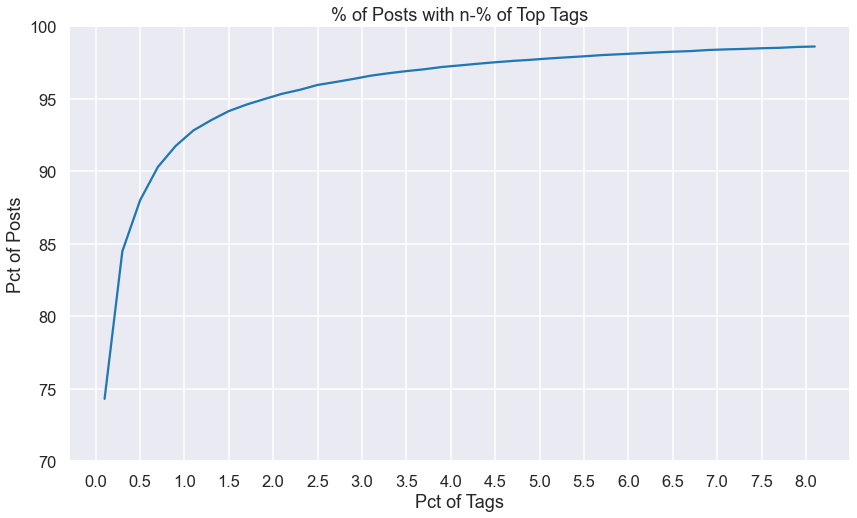

In [353]:
top_tag_counts, top_tag_pcts = tag_pcts_plot(tags)

In [366]:
def tag_rank_plot(tags):
    tag_per_id = tags.groupby('Id').size()
    id_per_tag = tags.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=False).reset_index().drop('index', axis=1)
        
    fig, ax = plt.subplots(figsize=(14,8))

    sns.lineplot(x=list(range(249,3001)), y=idtag_df.iloc[249:3001]['id_count'])

    ax.set_yticks(list(range(200,2001,200)))
    ax.set_xticks(list(range(250,3001,250)))
    
    ax.set_title("Tag Usage vs. Tag Rank")
    ax.set_xlabel('Tag Rank')
    ax.set_ylabel('Tag Usage')
    plt.savefig('./images/tag_usage.png')
    plt.show()
    
    return idtag_df

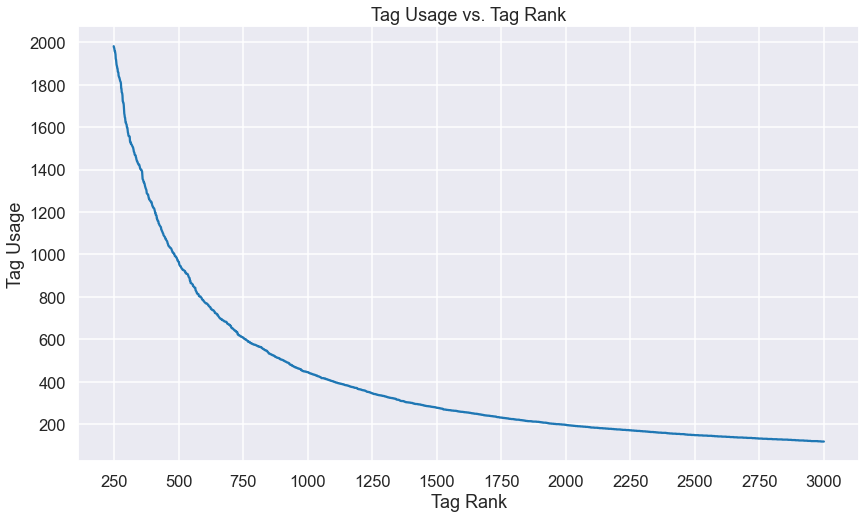

In [367]:
tag_counts = tag_rank_plot(tags)

In [347]:
model_tag_pct = tag_counts.iloc[:2000].id_count.sum()/len(tags)
print("Using only 2,000 tags, % of all tags (usage) included in model:", round(model_tag_pct*100, 2))

Using only 2,000 tags, % of all tags (usage) included in model: 83.28


In [359]:
top_tag_pcts[-16]

0.9778819442247211

Thus, I decided to settle on 2,000 top tags, which accounts for almost 98% of posts having at least one of the tags, and accounting for 83% of all tag usages. This allowed for a model that could be built and trained with a feasible amount of memory and training time, and achieved good results.

### Model selection

There are several options available for multi-label classification, but the most often-used are:

- One-vs-Rest
    - A collection of individual models for each tag (in this case, a SGD-Logistic Regression model)
- Classifier Chain
    - Similar to a decision tree, it filters posts through various classifiers to arrive at a collection of predicted tags

After experimenting with these options, the One-vs-Rest classifier made the most sense to use in this project. Using SGD-Logistic Regression allows for the individual models to train relatively quickly, and model has the ability to predict probabilities for each tag for each post, allowing for a ranked list to be created that can populate a predicted top-20 ranking for each post.

### Metrics

Since measures like accuracy, f1, etc become cumbersome when dealing with a vast number of target classes, there are two main metrics I used to determine the performance of the model.

#### Hamming loss
   - A calculation of similarity between two lists. This ranges from 0-1 (0 being best), and in this case, the values tend to be very small due to the large number of possible tags.
#### Top-20 Prediction metrics
   - This is my own method of determining how well the model does across all of the predictions. For each post, using the predicted probabilities, I can then calculate the following based on whether each post's actual set of tags are in the predicted list. The goal is to have all of the 'true' tags in the suggested tag list.
   - The two main measures are:
        - % of tags that exist in their post's predicted top-20
        - Average score of posts' tag set that are in the predicted top-20

In [6]:
def top20_score(y_pred, mlb, y_test, all_tags):
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    all_labels = list(mlb.classes_)
    
    model_tag_scores = []
    tag_scores = []
    
    each_tag_scores = {}
    for tag in all_tags:
        each_tag_scores[tag] = []
        
    post_scores = []
    for i, x in enumerate(y_test):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                model_tag_scores.append(1)
                each_tag_scores[y].append(1)
                post_score += 1
            else:
                tag_scores.append(0)
                if y in all_tags:
                    each_tag_scores[y].append(0)
                if y in labels and y in all_labels:
                    model_tag_scores.append(0)
        post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(post_scores), np.mean(tag_scores), np.mean(model_tag_scores),\
            ones/len(y_test), post_scores, each_tag_scores

In [7]:
def top20_model():
    grid_scores = {'samples':[], 'n_top':[], 'avg_post_score':[], 'pct_tags_top_n':[],\
                   'pct_model_tags_top_n':[], 'pct_perfect':[], 'hamming_loss':[]}


    print(f"Prepping {200000} samples for modelling")
    
    this_t = tags[tags['Id'].isin(qa_all['Id'].unique())]
    
    q_train = qa_all[:-40000]
    q_test = qa_all[-40000:]
    t_train = this_t[this_t['Id'].isin(q_train['Id'].unique())]
    t_test = this_t[this_t['Id'].isin(q_test['Id'].unique())]

    print(f'# of posts in train set: {len(q_train)}')
    print(f'# of posts in test set: {len(q_test)}')

    tag_per_id = t_train.groupby('Id').size()
    id_per_tag = t_train.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
    print('='*70)
    top = 2000
    print('='*70)
    print(f"Selecting top {top} tags...")
    top_tags = idtag_df.iloc[-top:].tag.values

    top_tag_ids = t_train[t_train['Tag'].isin(top_tags)]
    q_train = q_train[q_train['Id'].isin(top_tag_ids['Id'].unique())]
    print(f'# of posts in trimmed train set: {len(q_train)}')

    raw_ytrain = []
    for index, row in q_train[['tags']].iterrows():
        raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

    raw_ytest = []
    for index, row in q_test[['tags']].iterrows():
        raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))

    raw_ytest2 = []
    for index, row in q_test[['tags']].iterrows():
        raw_ytest2.append(set([x for x in row['tags']]))

    t0 = time()
    print('Encoding labels...')
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(raw_ytrain)
    y_test = mlb.transform(raw_ytest)

    print('Vectorizing text...')
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(q_train['text'])
    X_test = vectorizer.transform(q_test['text'])
    print(f'Encoding/vectorizing time: {time()-t0}')

    t0 = time()
    print("="*70)
    print('Fitting model...')
    sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
    sgd_log_clf.fit(X_train, y_train)
    print('Generating predictions...')
    predictions = sgd_log_clf.predict(X_test)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    print('Scoring model (hamming)...')
    hls = hamming_loss(y_test,predictions)
    print('Scoring model (top 20 scoring)...')

    y_pred = sgd_log_clf.predict_proba(X_test)
    del sgd_log_clf
    top20_scores = top20_score(y_pred, mlb, raw_ytest2, t_test['Tag'].unique())
    score_time = time() - t0
    print("Scoring time: %0.3fs" % score_time)

    grid_scores['samples'].append(200000)
    grid_scores['n_top'].append(top)
    grid_scores['avg_post_score'].append(top20_scores[0])
    grid_scores['pct_tags_top_n'].append(top20_scores[1])
    grid_scores['pct_model_tags_top_n'].append(top20_scores[2])
    grid_scores['pct_perfect'].append(top20_scores[3])
    grid_scores['hamming_loss'].append(hls)

    all_post_scores = top20_scores[4]
    all_tag_scores = top20_scores[5]
    grid_df = pd.DataFrame(grid_scores)
    display(grid_df)
    
    return grid_df, all_post_scores, all_tag_scores

In [8]:
grid_df, all_post_scores, all_tag_scores = top20_model()

Prepping 200000 samples for modelling
# of posts in train set: 160000
# of posts in test set: 40000
Selecting top 2000 tags...
# of posts in trimmed train set: 156115
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 12.587654113769531
Fitting model...
Generating predictions...
train time: 238.918s
Scoring model (hamming)...
Scoring model (top 20 scoring)...
Scoring time: 521.847s


,samples,n_top,avg_post_score,pct_tags_top_n,pct_model_tags_top_n,pct_perfect,hamming_loss
0,200000,2000,0.75271,0.732751,0.88751,0.472075,0.00097


In [10]:
np.mean(all_tag_scores['r'])

0.9705093833780161

In [14]:
tagscore_tag = []
tagscore_count = []
tagscore_score = []
for tag in list(all_tag_scores.keys()):
    this_scores = all_tag_scores[tag]
    if this_scores:
        tagscore_tag.append(tag)
        tagscore_count.append(len(this_scores))
        tagscore_score.append(np.mean(this_scores))

In [15]:
tagscores_df = pd.DataFrame()
tagscores_df['tag'] = tagscore_tag
tagscores_df['count'] = tagscore_count
tagscores_df['score'] = tagscore_score

<AxesSubplot:xlabel='count', ylabel='score'>

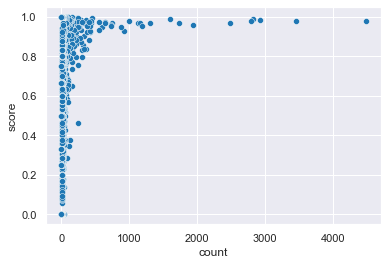

In [17]:
sns.scatterplot(data=tagscores_df, x='count', y='score')

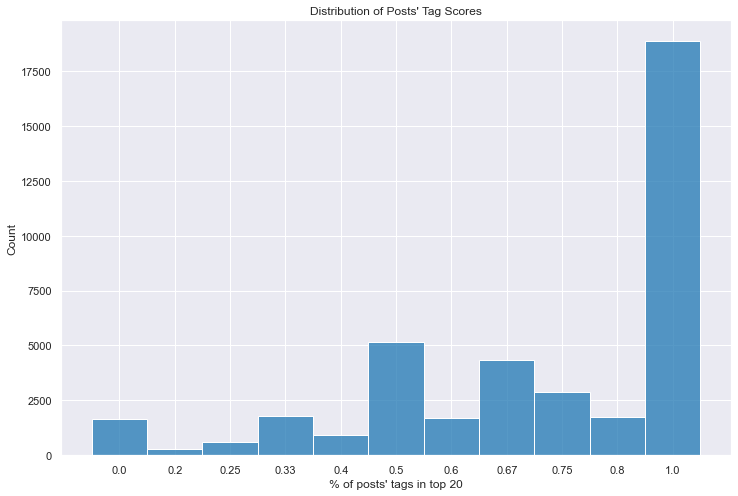

In [26]:
# Distribution of posts' top-20 prediction scores

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(x=sorted([str(round(x, 2)) for x in all_post_scores]))
ax.set_xlabel("% of posts' tags in top 20")
ax.set_title("Distribution of Posts' Tag Scores");

In [19]:
q_test = qa_all[-40000:].copy()

q_test['n_tags'] = q_test['tags'].apply(len)
q_test['top20_score'] = all_post_scores

In [31]:
q_test_df = q_test[['tags','n_tags','top20_score']].groupby('n_tags').mean().reset_index()

In [48]:
q_test_df

,n_tags,top20_score
0,1,0.829668
1,2,0.794878
2,3,0.750632
3,4,0.709167
4,5,0.677325


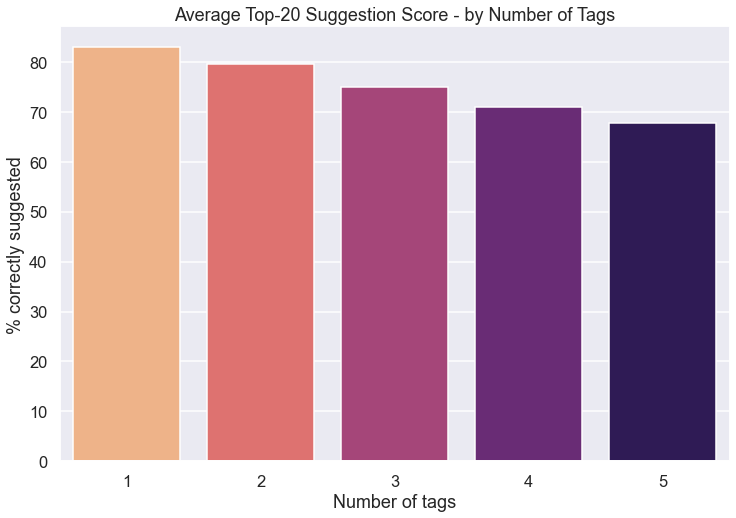

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set_context('talk')
sns.barplot(data=q_test_df, x='n_tags', y='top20_score', palette='magma_r')

ax.set_xlabel('Number of tags')
ax.set_ylabel('% correctly suggested')
ax.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8])
ax.set_yticklabels([0,10,20,30,40,50,60,70,80])
ax.set_title('Average Top-20 Suggestion Score - by Number of Tags');

plt.savefig('./images/top20_scores.png')

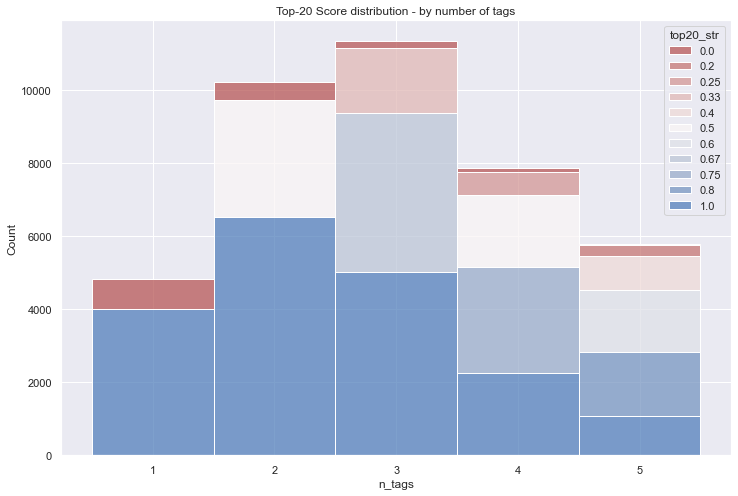

In [29]:
# Visualization of results - broken out by n_tags
q_test['top20_str'] = q_test['top20_score'].map(lambda x: round(x, 2)).map(str)

fig, ax = plt.subplots(figsize=(12,8))

hue_order = sorted(q_test['top20_str'].unique(), reverse=False)
sns.histplot(data=q_test, x='n_tags', hue='top20_str', hue_order=hue_order,\
             palette='vlag_r', multiple='stack', discrete=True)

ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title('Top-20 Score distribution - by number of tags');

![graph3](./images/tag_scores.png)

### Evaluation

Based on the scores above, and the visualizations of the results, the results are strong and encouraging.

Across all tags (not just the 2,000 used to build the model) over 75% are present in the predicted top-20. Just among the top 2,000, almost 89% are present.

The average proportion of a post's tags that are present in the predicted top-20 is 75%, and almost half are perfectly predicted.

The hamming loss metric is very very low, lower than the other results from the modelling experiments notebook.

***

In application to the business, this would be a good way to suggest tags to users. Since this is a relatively subjective thing (exactly which tags or amount of tags is best for a question is very subjective) complete accuracy may not be necessary. The intuition here is that this can be a useful tool for helping users select the proper tags at the moment they're posting it, and seeing them presented would save the user time.

In addition, it's not hard to imagine an implementation in which the user can either select or remove the suggested tags from the predicted list, and more results could populate it, increasing the likelihood of the 'true' tags appearing.

***

Although this is a large dataset, this is only 10% of the Stack Overflow questions from this period (2008-2016). With the full dataset, and more robust computational resources, an even larger and more complete model could possibly be constructed and yield even higher performance.

***
***

# Conclusions

***
## Recommendations

In both components of this project, the results suggest that these features could feasibly be developed based on the performance of the models.

### Question Quality

Even using a relatively small sample of posts, this model can be used to alert users when their post is likely to be low-quality.

Because there is still a %10 chance or so of mis-classifying a post, the alert would likely need to be worded so as not to be definitively 'this is a bad post!'. Finding the right balance between being clear and being respectful would be paramount.

Assuming Stack Overflow has a vast collection of more data, a larger and more robust model could be built that could likely do even better at flagging low-quality posts.

Overall, the ability to alert users could save time (both human and on the technical backend) in having to identify poor questions and either reach out to have them edited, or remove them. As well, it would hopefully lead to users being more likely to revise their questions and end up with a better contribution to the community.

### Tag Suggestion

Similarly, the tag prediction model here shows that it's possible to extend its use to creating a top-20 list of suggested tags, and that the predictions are accurate and will likely lead to users better tagging their posts.

Based on analysis, using a model with data only from recent post history is likely the best choice, to make sure that up-to-date tag and question relationships are being included in the model.

## Limitations and Future Work

Especially with the Tag Suggestion model, more work could likely be done to increase the various metrics and scores, and ensure that more of the 'true' tags are included in the predicted top-20 lists. More memory and computational resources would allow for larger and more in-depth modelling, and exploration of different, more expensive but possibly higher-performing models.

Beyond these models and goals, there are two areas I especially noticed might warrant further work.

### Tailored quality alerts

Exploration of whether there is a way to identify and alert users as to specific issues with a question that can be improved.

### Tag trend prediction

Exploration of whether predicting tag trends would be feasible, and possible connections to other datasets and intersections with the wider tech world.